In [1]:
import cv2 as cv
from os import path
import os
from glob import glob
from random import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import yaml

## Input

In [22]:
wsop_directory = "rank_suit_wsop" 
bg_directory = "dtd-r1/images"
polygon_path = "polygons/"
data_dir = "wsop_data"


## Define utility functions


In [3]:
def draw_polygon(img, polygon, gray=False):
    img_copy = img.copy()
    if gray:
        color = 255
    else:
        color = (255,0,0)
    if len(polygon) >= 3:
        pts = np.array(polygon, np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv.polylines(img_copy, [pts], True, color, 4)
    return img_copy


def plot_images(images):
    sizes = [image.shape for image in images]
    w = np.max([size[1] for size in sizes])
    h = np.max([size[0] for size in sizes])
    aspect_ratios = [size[1]*1.0/size[0] for size in sizes]
    fig, ax = plt.subplots(1, len(images), figsize=(3*len(images), 3), sharex=True, sharey=True)
    for i, image in enumerate(images):
        ax[i].imshow(image)
        ax[i].set_xlim(0, w)
        ax[i].set_ylim(0, h)
        ax[i].invert_yaxis()
        #ax[i].axis('off')
    plt.show()

# function for creating two corners of a rectangle based on mask
def get_corners(mask):
    mask = mask.reshape(mask.shape[0], mask.shape[1])
    # get the coordinates of the pixels in the mask
    coords = np.argwhere(mask)
    # get the bounding box of those pixels
    y_min = np.min(coords[:,0])
    y_max = np.max(coords[:,0])
    x_min = np.min(coords[:,1])
    x_max = np.max(coords[:,1])
    return (x_min, y_min), (x_max, y_max)

## Rescale the cards to have the same height

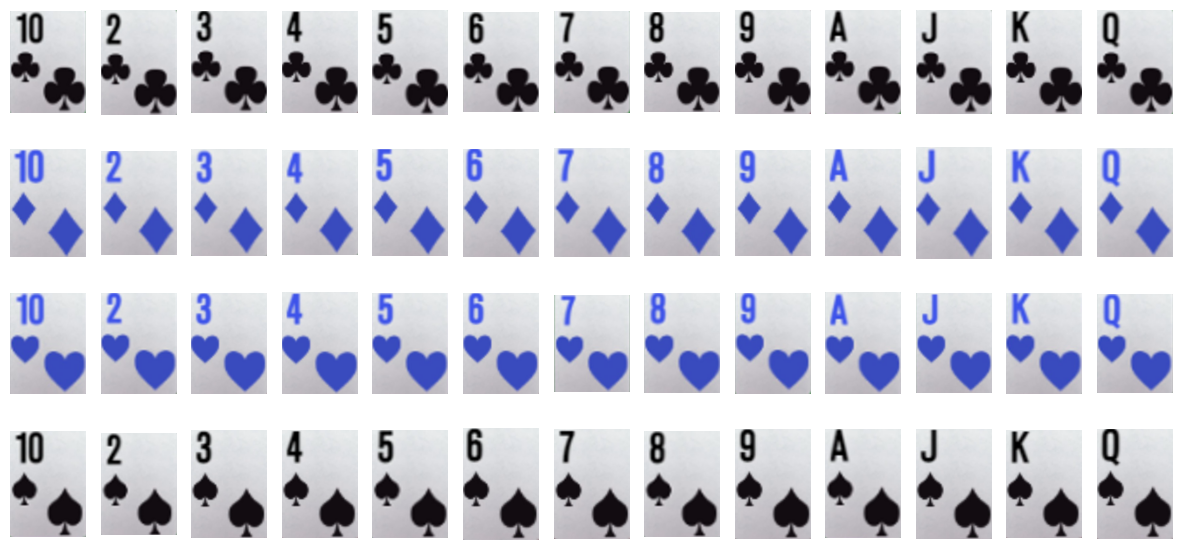

In [4]:

# get files in the directory
files = os.listdir(wsop_directory)
# load all images in the directory
# with red and blue switched
rank_suits = [f.split(".")[0] for f in files]

images = [cv.imread(path.join(wsop_directory, file)) for file in files]

# get the max width and height
max_width = max([img.shape[1] for img in images])
max_height = max([img.shape[0] for img in images])


plt.figure(figsize=(15, 7))
for i in range(13):
    for j in range(4):
        plt.subplot(4, 13, i + j*13 + 1)
        plt.imshow(images[i + j*13])
        plt.axis('off')

# replace the old images with the new ones
for i in range(len(images)):
    images[i] = cv.copyMakeBorder(images[i], 0, 0, 0, max_width - images[i].shape[1], cv.BORDER_CONSTANT, value=(255, 255, 255))
    

## Load polygon files

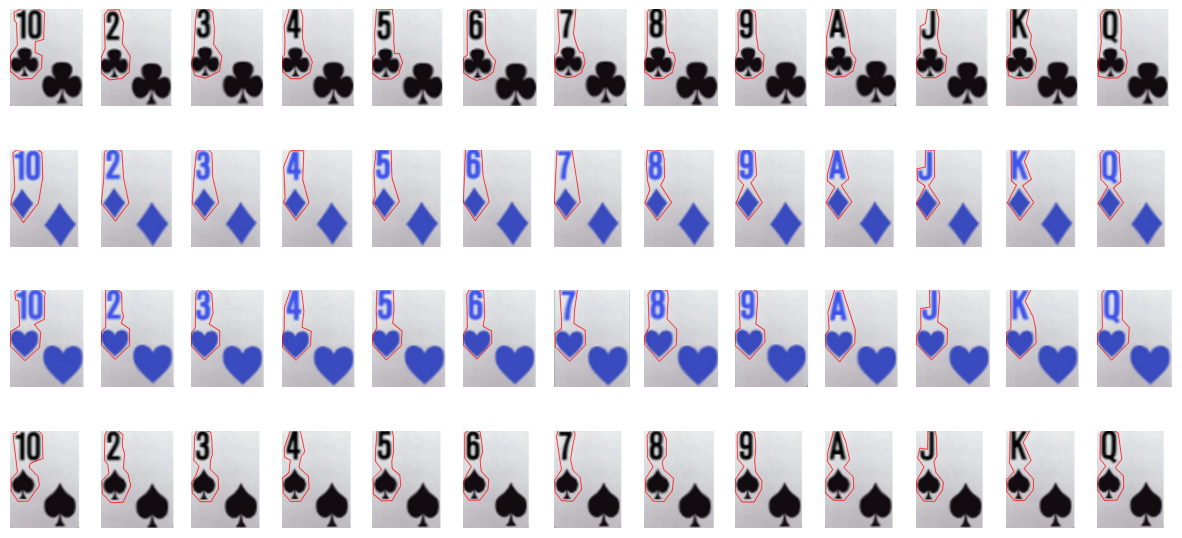

In [5]:

polygons = []
if not os.path.exists(polygon_path):    
    os.makedirs(polygon_path)
for i in range(len(images)):
    poly_path = os.path.join(polygon_path, files[i].split(".")[0] + ".npy")
    points = np.load(poly_path)
    polygons.append(points)    

plt.figure(figsize=(15, 7))
for i in range(13):
    for j in range(4):
        img = images[i + j*13]
        polygon = polygons[i + j*13]
        img_copy = draw_polygon(img, polygon, gray=False)

        plt.subplot(4, 13, i + j*13 + 1)
        plt.imshow(img_copy)
        plt.axis('off')

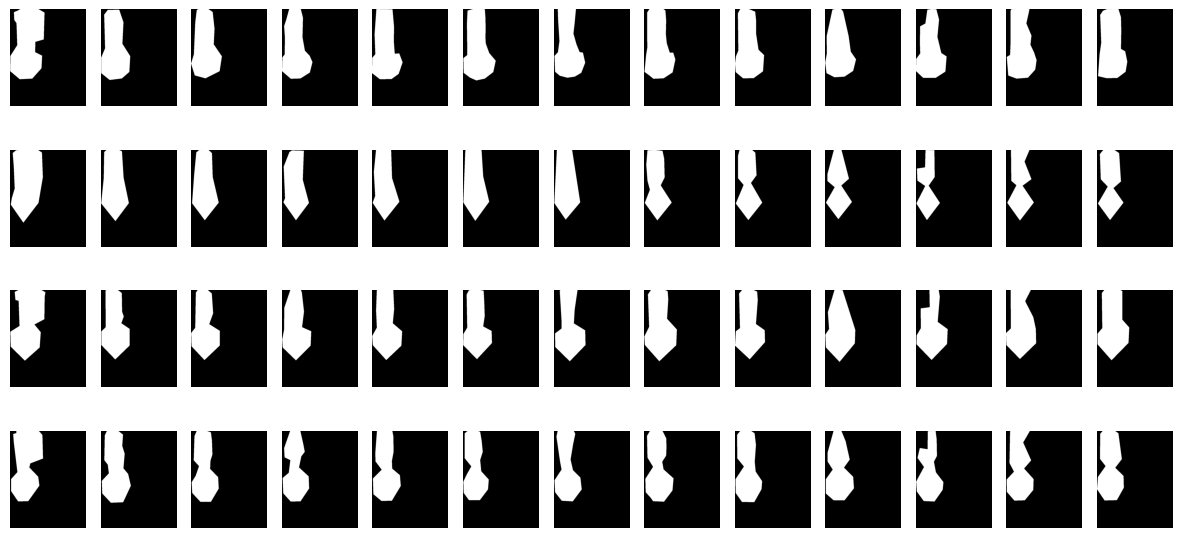

In [6]:
# get masks from polygons
rois = []
for i in range(len(images)):
    height, width = images[i].shape[:2]
    polygon = polygons[i]
    mask = np.zeros((height, width, 1), dtype=np.uint8)
    if len(polygon) >= 3:
        pts = np.array(polygon, np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv.fillPoly(mask, [pts], 1)
    rois.append(mask)

plt.figure(figsize=(15, 7))
for i in range(13):
    for j in range(4):
        plt.subplot(4, 13, i + j*13 + 1)
        plt.imshow(rois[i + j*13], cmap='gray')
        plt.axis('off')

## Image manipulation

### Rotate image and points


In [7]:
def rotate_image(img, angle, roi, mask=np.array([])):

    # Get the height and width of the image
    height, width = img.shape[:2]

    # Define the rotation angle in degrees and the rotation point

    rot_point = (width // 2, height // 2)

    # Calculate the rotation matrix using the rotation point and angle
    rot_matrix = cv.getRotationMatrix2D(rot_point, angle, 1.0)

    # Calculate the dimensions of the rotated image
    cos = abs(rot_matrix[0, 0])
    sin = abs(rot_matrix[0, 1])
    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))

    # Adjust the rotation matrix to take into account the new image dimensions
    rot_matrix[0, 2] += (new_width / 2) - rot_point[0]
    rot_matrix[1, 2] += (new_height / 2) - rot_point[1]

    # Apply the rotation to the image using the new dimensions
    rotated_img = cv.warpAffine(img, rot_matrix, (new_width, new_height))

    # rotate roi
    rotated_roi = cv.warpAffine(roi, rot_matrix, (new_width, new_height))
    rotated_roi = rotated_roi.reshape((new_height, new_width, 1)).astype(np.uint8)

    # get mask of rotated rectangle (black background)
    if len(mask) == 0:
        mask = np.ones((height, width, 1), dtype=np.uint8)
        rotated_mask = cv.warpAffine(mask, rot_matrix, (new_width, new_height))
    else:
        rotated_mask = cv.warpAffine(mask, rot_matrix, (new_width, new_height))
    rotated_mask = rotated_mask.reshape((new_height, new_width, 1)).astype(np.uint8)
    # mask = np.zeros_like(rotated_img)
    # cv.rectangle(mask, (0,0), (width,height), (255,255,255), -1)
    # mask = cv.warpAffine(mask, rot_matrix, (new_width, new_height))
    # mask = (mask==(255,255,255)).astype(np.uint8)
    

    return rotated_img, rotated_roi, rotated_mask


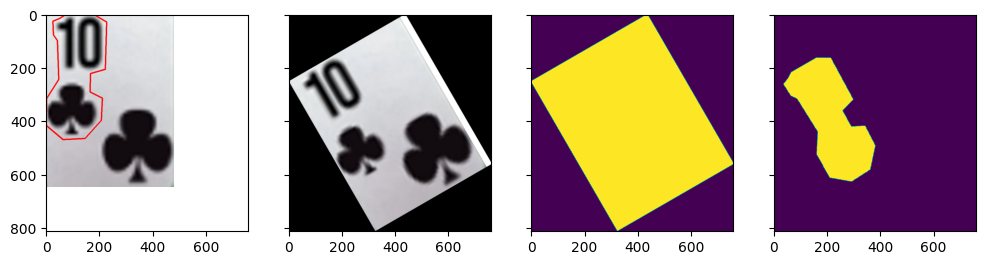

In [8]:
# test the rotate_image function
img = images[0]
polygon = polygons[0]
roi = rois[0]
img_poly = draw_polygon(img, polygon)

rotated_img, rotated_roi, mask = rotate_image(img, 30, roi)

plot_images([img_poly, rotated_img, mask, rotated_roi])

### Blur image

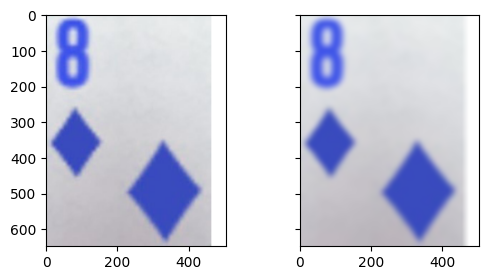

In [9]:
## Blur the image
def blur_image(img, kernel_size=(20, 20)):
    # Blur the image
    blurred_img = cv.blur(img, ksize=kernel_size)

    return blurred_img
# test the blur_image function
img = images[20]
blurred_img= blur_image(img)
plot_images([img, blurred_img])

### Scale the image

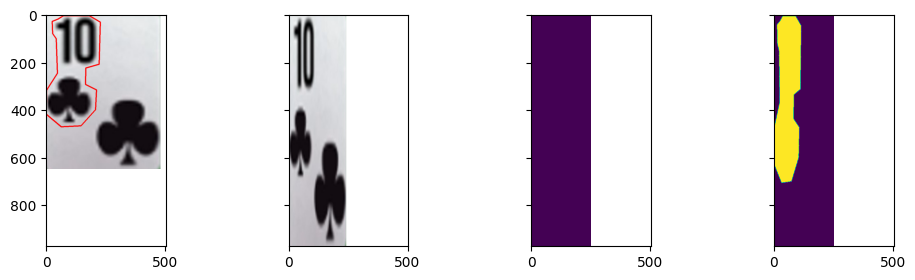

In [10]:
# Define a function to scale the image
def scale_image(img, roi, mask=np.array([]), fx=1.5, fy=1.5):
    
    # Scale the image
    scaled_img = cv.resize(img, None, fx=fx, fy=fy, interpolation=cv.INTER_CUBIC)
    scaled_height, scaled_width = scaled_img.shape[:2]
    # Scale the polygon
    scale_factor = np.array([fx, fy])  
    if len(mask) == 0:
        scaled_mask = np.ones((scaled_height, scaled_width, 1), dtype=np.uint8) 
    else:
        scaled_mask = cv.resize(mask, None, fx=fx, fy=fy, interpolation=cv.INTER_CUBIC) 
    scaled_mask = scaled_mask.reshape((scaled_height, scaled_width, 1)).astype(np.uint8)
    scaled_roi = cv.resize(roi, None, fx=fx, fy=fy, interpolation=cv.INTER_CUBIC)
    scaled_roi = scaled_roi.reshape((scaled_height, scaled_width, 1)).astype(np.uint8)
    return scaled_img, scaled_roi, scaled_mask

# test the scale_image function
img = images[0]
roi = rois[0]
polygon = polygons[0]
img_poly = draw_polygon(img, polygon, gray=True)
scaled_img, scaled_roi, mask = scale_image(img, roi, fx=0.5, fy=1.5)
plot_images([img_poly, scaled_img, mask, scaled_roi])



## Test with rotate, blur, and scale

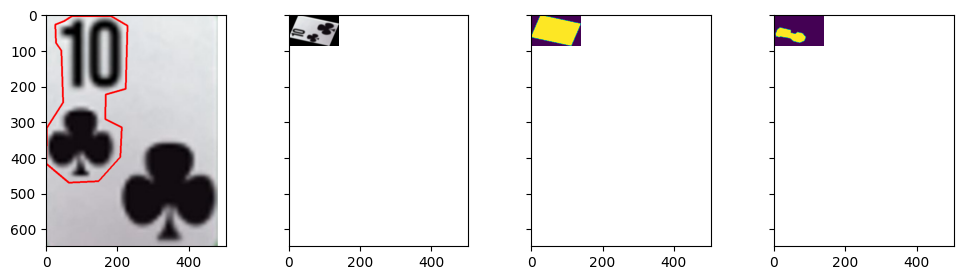

In [11]:

angle_range = (0,360)
kernel_range = (1,30)
fx_range = (0.1, 0.2)
fy_range = (0.1, 0.2)

import time

# set seed based on current time
np.random.seed(int(time.time()))


def augment_image(img, roi, mask=np.array([]), angle_range=(0,360), kernel_range=(0,30), fx_range=(0.1, 0.2), fy_range=(0.1, 0.2)):
    # rotate image
    angle = np.random.randint(angle_range[0], angle_range[1])
    rotated_img, rotated_roi, mask = rotate_image(img, angle, roi, mask=mask)
    

    # blur image
    kernel_size = (np.random.randint(kernel_range[0], kernel_range[1]), np.random.randint(kernel_range[0], kernel_range[1]))
    blurred_img = blur_image(rotated_img, kernel_size=kernel_size)
    # scale image
    fx = np.random.uniform(fx_range[0], fx_range[1])
    fy = np.random.uniform(fy_range[0], fy_range[1])
    scaled_img, scaled_roi, mask = scale_image(blurred_img, rotated_roi, mask=mask, fx=fx, fy=fy)
    return scaled_img, scaled_roi, mask


# test the augment_image function
img = images[0]
roi = rois[0]

polygon = polygons[0]
img_poly = draw_polygon(img, polygon, gray=True)
scaled_img, scaled_roi, mask = augment_image(img, roi, angle_range=angle_range, kernel_range=kernel_range, fx_range=fx_range, fy_range=fy_range)
plot_images([img_poly, scaled_img, mask*200, scaled_roi])



## Prepare background images

In [23]:
if not path.exists(bg_directory):
    # !wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
    # !tar xf dtd-r1.0.1.tar.gz
    os.system('wget --no-check-certificate https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.tar.gz')
    os.system('tar xf dtd-r1.tar.gz')


bg_files = glob(path.join(bg_directory,"*/*.jpg"))
num_bg = len(bg_files)
print("Number of background images:", num_bg)


Number of background images: 5640


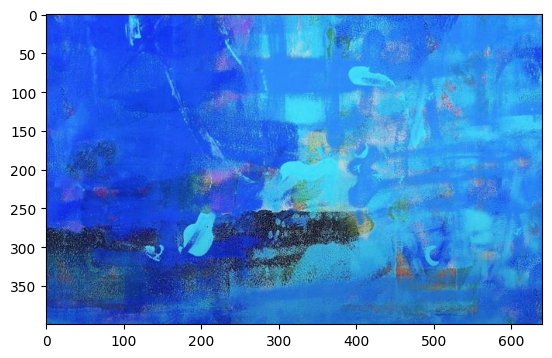

In [24]:
bg_img = cv.imread(bg_files[np.random.randint(0, num_bg)])
plt.imshow(bg_img)

## Paste cards to background image

In [14]:
# get polygon from mask
def get_polygon_from_mask(mask):
    # get the contours of the mask
    contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # get the polygon from the contour
    polygon = contours[0][:,0,:]
    return polygon



# Define a function to randomly place an image on a background image
def place_image(bg_img, rois_bg,  img, roi, img_mask, threshold = 0.1):
    # get the height and width of the background image
    bg_height, bg_width = bg_img.shape[:2]
    # get the height and width of the image to be placed
    img_height, img_width = img.shape[:2]
    # get the randome location of the image to be placed
    x = np.random.randint(0, bg_width - img_width)
    y = np.random.randint(0, bg_height - img_height)

    # rescale the image mask
    img_mask_scale = np.zeros((bg_height, bg_width, 1))
    img_mask_scale[y:y+img_height, x:x+img_width,:] = img_mask
    img_mask_scale = img_mask_scale.astype(np.uint8)


    # check if the image overlaps with any of the polygons
    areas = []
    new_rois = []
    for i in range(len(rois_bg)):
        roi_bg = rois_bg[i]['roi']
        covered_area = rois_bg[i]['covered_area']
        total_area = rois_bg[i]['total_area']
        new_roi = roi_bg * (1-img_mask_scale)
        area = np.sum(roi_bg * img_mask_scale)
        areas.append(area)
        new_rois.append(new_roi)
        if (covered_area + area)*1.0/total_area > threshold:
            return bg_img, rois_bg, False
    
    # update the covered area
    for i in range(len(rois_bg)):
        rois_bg[i]['covered_area'] += areas[i]
        rois_bg[i]['roi'] = new_rois[i]


    # place the image on the background
    img_scale = np.zeros_like(bg_img)
    img_scale[y:y+img_height, x:x+img_width] = img
    bg_img = bg_img * (1-img_mask_scale)
    bg_img += img_scale * img_mask_scale

    # create a mask from roi
    roi_bg = {}

    roi_mask = np.zeros((bg_height, bg_width, 1))
    roi_mask[y:y+img_height, x:x+img_width] = roi
    roi_mask = roi_mask.astype(np.uint8)
    roi_bg['roi'] = roi_mask
    roi_bg['covered_area'] = 0
    roi_bg['total_area'] = np.sum(roi_mask)
    rois_bg.append(roi_bg)

    return bg_img, rois_bg, True



    

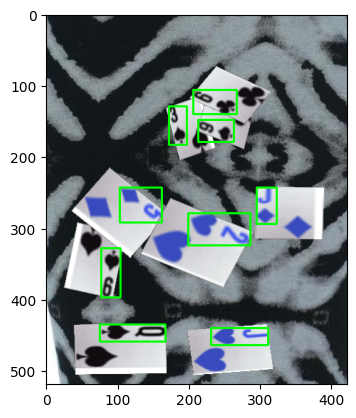

In [15]:


def place_cards(bg_file, images, rois, iteration= 10, threshold = 0.2,angle_range=(0,360), kernel_range=(1,30), fx_range=(0.1,0.2), fy_range=(0.1,0.2)):
    bg_img = cv.imread(bg_file)
    rois_bg = []
    image_idx = []
    threshold = 0.1
    for _ in range(iteration):
        # randomly select an image
        num_images = len(images)
        # randome index 
        index = np.random.randint(0, num_images)
        img = images[index]
        roi = rois[index]
        # augment the image
        scaled_img, scaled_polygon, mask = augment_image(img, roi, angle_range=angle_range, kernel_range=kernel_range, fx_range=fx_range, fy_range=fy_range)

        bg_img, rois_bg, success = place_image(bg_img, rois_bg, scaled_img, scaled_polygon, mask, threshold=threshold)
        if success:
            image_idx.append(index)

    boxes = []
    for roi in rois_bg:
        xy0, xy1 = get_corners(roi['roi'])
        boxes.append((xy0, xy1))

    return bg_img, boxes, image_idx

# randomly select a background image file
bg_file = bg_files[np.random.randint(0, num_bg)]

bg_img, boxes, image_idx = place_cards(bg_file, images, rois)

# draw the boxes
for box in boxes:
    cv.rectangle(bg_img, box[0], box[1], (0,255,0), 2)


plt.imshow(bg_img)

## Create data directory for yolov7

In [16]:

if not path.exists(data_dir):
    os.makedirs(data_dir)


In [17]:
# function to return label texts
def get_label_text(bg_img, image_idx, boxes):
    h, w = bg_img.shape[:2]
    label_text = ""
    for i in range(len(image_idx)):
        (x_0, y_0), (x_1, y_1) = boxes[i]
        # convert them to relative coordinates
        x_0 = x_0*1.0/w
        y_0 = y_0*1.0/h
        x_1 = x_1*1.0/w
        y_1 = y_1*1.0/h
        # get center coordinates
        x_c = (x_0 + x_1)/2
        y_c = (y_0 + y_1)/2
        # get width and height
        rect_width = x_1 - x_0
        rect_height = y_1 - y_0

        label_text += "{} {} {} {} {}\n".format(image_idx[i], x_c, y_c, rect_width, rect_height)
    return label_text


# functioin for generating data
def generate_data(directory, num_data, bg_files, images, rois, iteration= 10,
                  threshold = 0.2,angle_range=(0,360), 
                  kernel_range=(1,30), fx_range=(0.1,0.2), fy_range=(0.1,0.2)):
    # create the directory if it does not exist
    if path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

    # get the number of background images
    num_bg = len(bg_files)
    # create images directory
    images_dir = path.join(directory, "images")
    if not path.exists(images_dir):
        os.makedirs(images_dir)
    # create labels directory
    labels_dir = path.join(directory, "labels")
    if not path.exists(labels_dir):
        os.makedirs(labels_dir)
    
    # iterate over the number of data
    # start progress bar
    
    for i in tqdm(range(num_data)):
        # randomly select a background image file
        bg_file = bg_files[np.random.randint(0, num_bg)]
        # place the cards
        bg_img, boxes, image_idx = place_cards(bg_file, images, rois, iteration= iteration,threshold=threshold, 
                                               angle_range=angle_range, kernel_range=kernel_range, 
                                               fx_range=fx_range, fy_range=fy_range)
        # save the image
        cv.imwrite(path.join(images_dir, "{}.jpg".format(i)), bg_img)
        # get the label text
        label_text = get_label_text(bg_img, image_idx, boxes)
        # save the label text
        with open(path.join(labels_dir, "{}.txt".format(i)), "w") as f:
            f.write(label_text)


In [18]:
train_dir = path.join(data_dir, "train")
n_train = 100 ## keeping it small for demonstration. I did 20000 for my project
generate_data(train_dir, n_train, bg_files, images, rois)

valid_dir = path.join(data_dir, "valid")
n_valid = 100 ## keeping it small for demonstration. I did 2000 for my project
generate_data(valid_dir, n_valid, bg_files, images, rois)

test_dir = path.join(data_dir, "test")
n_test = 100 ## keeping it small for demonstration
generate_data(test_dir, n_test, bg_files, images, rois)


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


In [19]:
# Create data.yaml file
def create_yaml_text(data_dir, classes):
    data_yaml = dict(
        train = path.join('../'+path.basename(data_dir)+ '/train/images'),
        val = path.join('../'+path.basename(data_dir)+ '/valid/images'),
        nc = len(classes),
        names = classes
    )
    return data_yaml

data_yaml = create_yaml_text(data_dir, rank_suits)
data_yaml_path = path.join(data_dir, "data.yaml")
with open(data_yaml_path, "w") as f:
    yaml.dump(data_yaml, f)
    

